In [45]:
from sstadex import Macromodel, Test, cs_pmos, Primitive, dfs, diffpair_cc, current_mirror_cc, spice_sim, cm_pmos
from sympy import Symbol
from sympy import lambdify

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib.colors import LogNorm

import paretoset as pareto

import seaborn as sns
sns.set_theme()
sns.color_palette("mako")

sys.path.insert(0, "../../..")
from gmid.mosplot import load_lookup_table, LoadMosfet

In [46]:
## Exploration parameters

N_points = 10
lengths_nmos = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]
lengths_pmos = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]

lut_file = "../../LUTs/sky130A_LUT_lvt.npy"
lut_w = 20e-6

## Electrical parameters

Vout = 1.2                                      # LDO output voltage
Vin = 1.8                                    # LDO supply voltage
Vref = 0.9                                      # LDO voltage reference
IL = 5e-3                                     # Load current
CL = 0.5e-12                                    # Load capacitance
RL = Vout/IL

## LDO specifications

efficiency = 0.98
psrr_condition = -70
estability_condition = 60
linereg_condition = 0.5
loadreg_condition = 0.7
#iq_condition = 20e-6
size_condition = 1e-3

I_bias = 5e-6
I_amp1 = 10e-6 # considering the two branches of differential pair
I_amp2 = 60e-6

Iq_max = IL*(1-efficiency)
Ib_pt = Iq_max-I_amp2-I_bias

R1 = (Vout-Vref)/Ib_pt
R2 = Vref*R1/(Vout-Vref)

LDO = pd.DataFrame.from_dict({'Vout': [Vout], 'Vin': [Vin], 'Vref': [Vref], 'IL': [IL], 'CL': [CL], 'RL': [RL], 'Iq_max': [Iq_max], 'Ib_pt': [Ib_pt], 'R1': [R1], 'R2': [R2]}, orient='index', columns=['Value'])
LDO

,Value
Vout,1.200000e+00
Vin,1.800000e+00
Vref,9.000000e-01
IL,5.000000e-03
CL,5.000000e-13
RL,2.400000e+02
Iq_max,1.000000e-04
Ib_pt,3.500000e-05
R1,8.571429e+03
R2,2.571429e+04


In [47]:
Vota = 1.122

In [48]:
## LDO MACROMODEL

LDO_macro = Macromodel(
    name ='LDO_macro', 
    outputs= [
        Symbol("W_diff_m1"), Symbol("L_diff_m1"),
        Symbol("W_diff_m2"), Symbol("L_diff_m2"),
        Symbol("W_aload_m1"), Symbol("L_aload_m1"),
        Symbol("W_aload_m2"), Symbol("L_aload_m2"),
        Symbol("W_cs"), Symbol("L_cs"),
        Symbol("W_pt"), Symbol("L_pt"),
        Symbol("W_cc"), Symbol("L_cc"),
        Symbol("W_rc"), Symbol("L_rc")],
    electrical_parameters={
        "Vdd": Vin, 
        "Vref": Vref, 
        "Vout": Vout, 
        "Vota": Vota,
        "Il": IL+Ib_pt}
    )

## OTA CASCODE DIFFPAIR MACROMODEL

OTA_macro = Macromodel(
    name = 'OTA_macro',
    outputs = [
        Symbol("W_diff_m1"), Symbol("L_diff_m1"),
        Symbol("W_diff_m2"), Symbol("L_diff_m2"),
        Symbol("W_aload_m1"), Symbol("L_aload_m1"),
        Symbol("W_aload_m2"), Symbol("L_aload_m2"),
        Symbol("W_cs"), Symbol("L_cs"),
        Symbol('vgs_cs')
    ],
    electrical_parameters = {
        "Vdd": LDO_macro.electrical_parameters["Vdd"],
        "Vref": LDO_macro.electrical_parameters["Vref"],
        "Vout": LDO_macro.electrical_parameters["Vota"],
        "Il": I_amp2},
    macromodel_parameters={
        Symbol('Ra'): np.logspace(3, 7, N_points),
        Symbol('gma'): np.logspace(-5, -2, N_points)}
    )

In [49]:
psrr_LDO_macro = Test()
psrr_LDO_macro.name = "psrr_LDO"
psrr_LDO_macro.tf = ["vout", "vdd"]
psrr_LDO_macro.netlist = "ldo"
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("s"): 0,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

psrr_LDO_macro.opt_goal = "min"
psrr_LDO_macro.conditions = {"max": [10**(100/20)]}
psrr_LDO_macro.variables = {}
psrr_LDO_macro.out_def = {"eval": psrr_LDO_macro.tf}

##############################################################################

dc_LDO_macro = Test()
dc_LDO_macro.name = "dc_LDO"
dc_LDO_macro.tf = ["vout", "vdd"]
dc_LDO_macro.netlist = "ldo"
dc_LDO_macro.parametros = {Symbol("V1"): Vin,
                           Symbol("V2"): Vref,
                           Symbol("s"): 0,
                           Symbol("Rl"): RL,
                           Symbol("Cl"): CL,
                           Symbol("R1"): R1, 
                           Symbol("R2"): R2}

dc_LDO_macro.opt_goal = "min"
dc_LDO_macro.conditions = {"min": [0]}
dc_LDO_macro.variables = {}
dc_LDO_macro.out_def = {"eval": dc_LDO_macro.tf}
x = Symbol("x")
dc_LDO_macro.lamd = lambdify(x, x*3.3)

##############################################################################

gain_ol_LDO_macro = Test()
gain_ol_LDO_macro.name = "gain_ol_LDO"
gain_ol_LDO_macro.tf = ["vout", "vol"]
gain_ol_LDO_macro.netlist = "ldo_ol"
gain_ol_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("s"): 0,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

gain_ol_LDO_macro.opt_goal = "min"
gain_ol_LDO_macro.conditions = {"min": [1]}
gain_ol_LDO_macro.variables = {}
gain_ol_LDO_macro.out_def = {"eval": gain_ol_LDO_macro.tf}

##############################################################################

phase_margin_LDO_macro = Test()
phase_margin_LDO_macro.name = "phase_margin_LDO"
phase_margin_LDO_macro.tf = ["vout", "vol"]
phase_margin_LDO_macro.netlist = "ldo_ol"
phase_margin_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

phase_margin_LDO_macro.opt_goal = "min"
phase_margin_LDO_macro.conditions = {"min": [-300]}
phase_margin_LDO_macro.variables = {}
phase_margin_LDO_macro.out_def = {"pm": phase_margin_LDO_macro.tf}

In [50]:
gain_OTA = Test()
gain_OTA.tf = ("vout", "vpos")
gain_OTA.name = "gain_OTA"
gain_OTA.netlist = "ota_1stage"
gain_OTA.parametros = {
    Symbol("gaload_2"): Symbol("gaload_1"),
    Symbol("Raload_2"): Symbol("Raload_1"),
    Symbol("gdiff_2"): Symbol("gdiff_1"), 
    Symbol("Rdiff_2"): Symbol("Rdiff_1"),
    Symbol("V1"): 0,
    Symbol("V_b"): 0,
    Symbol("V_n"): 0,
    Symbol("V_p"): 1,
    Symbol("I2"): 0,
    Symbol("s"): 0,
    Symbol("Cl"): 1e-1}

gain_OTA.opt_goal = "max"
gain_OTA.conditions = {"min": [10**(-100/20)]}
gain_OTA.variables = {}
gain_OTA.out_def = {"eval": gain_OTA.tf}

#########################################################

phase_margin_OTA = Test()
phase_margin_OTA.name = "phase_margin_OTA"
phase_margin_OTA.tf = ["vout", "vpos"]
phase_margin_OTA.netlist = "OpAmp_2stage"
phase_margin_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("Vpos"): 1,
    Symbol("Cin_pt"): 1e-12}

phase_margin_OTA.opt_goal = "min"
phase_margin_OTA.conditions = {"min": [0]}
phase_margin_OTA.variables = {}
phase_margin_OTA.out_def = {"pm": phase_margin_OTA.tf}

##########################################################

rout_OTA = Test()
rout_OTA.name = "rout_OTA"
rout_OTA.target_param = Symbol("Ra")
rout_OTA.tf = ["vout", "vr"]
rout_OTA.netlist = "ota_1stage_rout"
rout_OTA.parametros = {Symbol("gdiff_2"): Symbol("gdiff_1"),
                              Symbol("Rdiff_2"): Symbol("Rdiff_1"),
                                Symbol("gaload_2"): Symbol("gaload_1"),
                                Symbol("Raload_2"): Symbol("Raload_1"),
                                Symbol("V1"): 0,
                                Symbol("V_n"): 0,
                                Symbol("V_p"): 0,
                                Symbol("Vr"): 1,
                                Symbol("I2"): 0,
                                Symbol("s"): 0,
                                Symbol("Rr"): 1000,
                                Symbol("Cl"): 1e-12}

rout_OTA.opt_goal = "max"
rout_OTA.conditions = {"min": [1]}
x = Symbol("x")
rout_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_OTA.variables = {}
rout_OTA.out_def = {"eval": rout_OTA.tf}

##########################################################

gm_OTA = Test()
gm_OTA.target_param = Symbol("gma")
gm_OTA.name = "gm_OTA"
gm_OTA.tf = ["vout", "vpos"]
gm_OTA.netlist = "ota_1stage"
gm_OTA.composed = 1
gm_OTA.out_def = {"divide": [gain_OTA, rout_OTA]}
gm_OTA.opt_goal = "max"
gm_OTA.conditions = {"min": [0.000000001]}

In [51]:
pt = cs_pmos(
    lut_file=lut_file,
    lut_w=lut_w,
    netlist='pmos_cm.spice', 
    type='pmos', 
    inputs={
        'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
        'vgs_lut': (-1.8, -0.1, 0.01), 
        'vgs': LDO_macro.electrical_parameters["Vota"]-Vin, 
        'il': LDO_macro.electrical_parameters["Il"],
        'length': lengths_pmos, 
        '2d_var': ['length', 'vgs']})

pt_df = pt.build()

mask = (pt_df["width"]>5e-6) & (pt_df["width"]<15e-3)

pt_df = pt_df[mask]

pt.parameters = {
    Symbol('gm_pt'): pt_df['gm'].values,
    Symbol('Ro_pt'): pt_df['Ro'].values,
    Symbol("Cgg_pt"): pt_df['cgg'].values,
    Symbol("Cgd_pt"): pt_df['cgd'].values,
    Symbol("Cin_pt"): pt_df['cgg'].values+pt_df["cgd"].values*pt_df["gm"].values*pt_df["Ro"].values,
    Symbol("dropout"): 2/(pt_df["gm"].values/pt.inputs['il']),
    Symbol('Vota'): np.tile(LDO_macro.electrical_parameters["Vota"], 5)[mask]}

pt.outputs = {
    Symbol("W_pt"): pt_df["width"].values,
    Symbol("L_pt"): pt_df["length"].values}

# CASE 2: WITHOUT LOAD

## found operation point of the circuit with no load
lookup_table = load_lookup_table(lut_file)

pt_lutable = LoadMosfet(
            lookup_table=lookup_table,
            mos='pmos',
            vsb=0,
            vds=LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"],
            vgs=(-1.8, -0.1, 0.01),
            lengths=lengths_pmos,
        )

jd_2 = Ib_pt/pt.W.flatten()

vgs_2 = pt_lutable.interpolate(
            x_expression=pt_lutable.current_density_expression,
            x_value=jd_2,
            y_expression=pt_lutable.lengths_expression,
            y_value=pt.L.flatten(),
            z_expression=pt_lutable.vgs_expression,
        )

vgs_2 = np.diag(vgs_2)
print("Values of Vgs_pt when there is no load: ", vgs_2)
##

vout_2stage_wc = vgs_2

pt_wc = cs_pmos(
    lut_file=lut_file,
    lut_w=lut_w,
    netlist='pmos_cm.spice', 
    type='pmos', 
    inputs={
        'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
        'vgs_lut': (-1.8, -0.1, 0.01), 
        'vgs': vout_2stage_wc, 
        'il': Ib_pt,
        'length': pt.L.flatten(), 
        '2d_var': ['length', 'vgs']})

pt_wc_df = pt_wc.build()

pt_wc.parameters = {
    Symbol('gm_pt'): pt_wc_df["gm"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol('Ro_pt'): pt_wc_df["Ro"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol("Cgg_pt"): pt_wc_df["cgg"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol("Cgd_pt"): pt_wc_df["cgd"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol("dropout"): 2/(pt_wc_df["gm"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask]/pt_wc.inputs['il']),
    Symbol("Cin_pt"): pt_wc_df["cgg"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask]
                        +pt_wc_df["cgd"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask]
                        *pt_wc_df["gm"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask]*pt_wc_df["Ro"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol('Vota'): Vin+vout_2stage_wc[mask]}

pt_wc.outputs = {
    Symbol("W_pt"): pt_df["width"].values,
    Symbol("L_pt"): pt_df["length"].values}

length
vgs
0
Values of Vgs_pt when there is no load:  [-0.25136949 -0.32188931 -0.34006522 -0.33640142 -0.33979463]
length
vgs
0


In [52]:
sweep_size_dp = 5
vin_dp = OTA_macro.electrical_parameters["Vref"]
vout_dp = OTA_macro.electrical_parameters["Vout"]
vs_dp = np.linspace(0.1, vin_dp-0.1, sweep_size_dp)
vcp_dp = np.linspace(vin_dp, vout_dp-0.1, sweep_size_dp)

diffpair_primitive = diffpair_cc(
    vcp_dp, 
    vs_dp, 
    vin_dp, 
    vout_dp, 
    I_amp2/2, 
    sweep_size_dp, 
    lengths_nmos, 
    vout_dp + 0.5,
    lut_file,
    lut_w)

diffpair_primitive_df =  diffpair_primitive.build()

diffpair_primitive_mask = (diffpair_primitive_df["width_m1"]>1e-6) & (diffpair_primitive_df["width_m2"]>2e-6) & (diffpair_primitive_df["width_m1"]<4e-6) & (diffpair_primitive_df["width_m2"]<1e-4)

diffpair_primitive_df = diffpair_primitive_df[diffpair_primitive_mask]

diffpair_primitive.parameters = {Symbol("Rdiff_1"): diffpair_primitive_df["Ro"].values, 
                                 Symbol("gdiff_1"): diffpair_primitive_df["gm"].values,
                                 Symbol("vbias"): diffpair_primitive_df["vbias"].values,
                                 Symbol("vs_diff"): diffpair_primitive_df["vs"].values}

diffpair_primitive.outputs = {Symbol("W_diff_m1"): diffpair_primitive_df["width_m1"].values,
                              Symbol("W_diff_m2"): diffpair_primitive_df["width_m2"].values,
                              Symbol("L_diff_m1"): diffpair_primitive_df["length_m1"].values,
                              Symbol("L_diff_m2"): diffpair_primitive_df["length_m2"].values}

## OTA stage1 active load ################################################################

vout_cm = 1.12 - Vin
sweep_size_cm = 5

vcp_cm = np.linspace(vout_cm+0.1, -0.1, sweep_size_cm)

print("vout_cm: ", vout_cm)
print("vcp_cm: ", vcp_cm)

activeload_primmitive = current_mirror_cc(
    vcp_cm, 
    vout_cm, 
    I_amp2/2, 
    sweep_size_cm, 
    lengths_nmos, 
    vout_cm - 0.5,
    lut_file,
    lut_w)

activeload_primitive_df = activeload_primmitive.build()

activeload_primitive_mask = (activeload_primitive_df["width_m1"]>1e-6) & (activeload_primitive_df["width_m2"]>5e-6) & (activeload_primitive_df["width_m1"]<1e-4) & (activeload_primitive_df["width_m2"]<1e-4)
activeload_primitive_df = activeload_primitive_df[activeload_primitive_mask]

activeload_primmitive.parameters = {Symbol("Raload_1"): activeload_primitive_df["Ro"].values,
                                    Symbol("gaload_1"): activeload_primitive_df["gm"].values,
                                    Symbol("vbias_cm"): activeload_primitive_df["vbias"].values}
activeload_primmitive.outputs = {Symbol("W_aload_m1"): activeload_primitive_df["width_m1"].values,
                                 Symbol("L_aload_m1"): activeload_primitive_df["length_m1"].values,
                                 Symbol("W_aload_m2"): activeload_primitive_df["width_m2"].values,
                                 Symbol("L_aload_m2"): activeload_primitive_df["length_m2"].values}
                                 

#############################################################################

currentsource = cm_pmos()
currentsource.parameters = {
    Symbol('gcs'): [],
    Symbol('Rcs'): [],
    Symbol('vs_cs'): [],
    Symbol('vgs_cs'): []}
currentsource.outputs = {
    Symbol("W_cs"): [],
    Symbol("L_cs"): []}

for vds_cs in vs_dp:

    vgs_cs = np.linspace(vds_cs-0.2, vds_cs+0.6, 5)

    currentsource_aux = cm_pmos(
        lut_file=lut_file,
        lut_w=lut_w,
        netlist='pmos_cs.spice',
        type='nmos',
        inputs={
            'vds_lut': vds_cs, 
            'vgs_lut': (0.1, 1.8, 0.01), 
            'vgs': vgs_cs, 
            'il': I_amp2,
            'length': lengths_nmos, 
            '2d_var': ['length', 'vgs']})
    currentsource_aux.build()

    currentsource.parameters[Symbol('gcs')].append(np.asarray(currentsource_aux.gm).flatten())
    currentsource.parameters[Symbol('Rcs')].append(np.asarray(currentsource_aux.Ro).flatten())
    currentsource.parameters[Symbol('vs_cs')].append(np.asarray(np.repeat(vds_cs, len(lengths_nmos)*len(vgs_cs))).flatten())
    currentsource.parameters[Symbol('vgs_cs')].append(np.asarray(np.tile(vgs_cs, len(lengths_nmos))).flatten())
    currentsource.outputs[Symbol('W_cs')].append(np.asarray(currentsource_aux.W).flatten())
    currentsource.outputs[Symbol('L_cs')].append(np.asarray(currentsource_aux.L).flatten())


currentsource.parameters[Symbol('gcs')] = np.asarray(currentsource.parameters[Symbol('gcs')]).flatten()
currentsource.parameters[Symbol('Rcs')] = np.asarray(currentsource.parameters[Symbol('Rcs')]).flatten()
currentsource.parameters[Symbol('vs_cs')] = np.asarray(currentsource.parameters[Symbol('vs_cs')]).flatten()
currentsource.parameters[Symbol('vgs_cs')] = np.asarray(currentsource.parameters[Symbol('vgs_cs')]).flatten()
currentsource.outputs[Symbol('W_cs')] = np.asarray(currentsource.outputs[Symbol('W_cs')]).flatten()
currentsource.outputs[Symbol('L_cs')] = np.asarray(currentsource.outputs[Symbol('L_cs')]).flatten()
currentsource.outputs[Symbol('vgs_cs')] = currentsource.parameters[Symbol('vgs_cs')]

mask = (currentsource.outputs[Symbol('W_cs')]<3e-4) & (currentsource.outputs[Symbol('W_cs')]>1e-6)

currentsource.parameters[Symbol('gcs')] = np.asarray(currentsource.parameters[Symbol('gcs')]).flatten()[mask]
currentsource.parameters[Symbol('Rcs')] = np.asarray(currentsource.parameters[Symbol('Rcs')]).flatten()[mask]
currentsource.parameters[Symbol('vs_cs')] = np.asarray(currentsource.parameters[Symbol('vs_cs')]).flatten()[mask]
currentsource.parameters[Symbol('vgs_cs')] = np.asarray(currentsource.parameters[Symbol('vgs_cs')]).flatten()[mask]
currentsource.outputs[Symbol('W_cs')] = np.asarray(currentsource.outputs[Symbol('W_cs')]).flatten()[mask]
currentsource.outputs[Symbol('L_cs')] = np.asarray(currentsource.outputs[Symbol('L_cs')]).flatten()[mask]
currentsource.outputs[Symbol('vgs_cs')] = currentsource.parameters[Symbol('vgs_cs')]

vds
vgs
1
M1 jd:  [[2.85414115e+01 5.19950502e+00 1.52638846e-01 1.43286926e-03
  9.02226846e-06 2.86615670e+01 5.23428197e+00 1.54669082e-01
  1.45628403e-03 9.35131326e-06 2.87784715e+01 5.26846194e+00
  1.56679911e-01 1.48106733e-03 9.61295900e-06 2.88924899e+01
  5.30173157e+00 1.58698152e-01 1.50657385e-03 9.84225025e-06
  2.90039480e+01 5.33607441e+00 1.60691664e-01 1.52986293e-03
  1.00536387e-05]
 [1.67989462e+01 3.81075017e+00 1.56665879e-01 1.46128235e-03
  7.75901808e-06 1.68420860e+01 3.82659895e+00 1.58163537e-01
  1.47862049e-03 7.96407123e-06 1.68841775e+01 3.84224214e+00
  1.59653540e-01 1.49784918e-03 8.12249846e-06 1.69253547e+01
  3.85750433e+00 1.61161004e-01 1.51815516e-03 8.26105166e-06
  1.69657584e+01 3.87335517e+00 1.62653098e-01 1.53638129e-03
  8.39005852e-06]
 [9.66207010e+00 2.54120557e+00 1.44304586e-01 1.36692466e-03
  5.83677543e-06 9.67983993e+00 2.54864562e+00 1.45319685e-01
  1.37968130e-03 5.96118241e-06 9.69719329e+00 2.55600292e+00
  1.46331303e-01

In [53]:
vout_2stage_wc = 1.5

In [54]:
diffpair_primitive_wc = diffpair_cc(
    vcp_dp, 
    vs_dp, 
    vin_dp, 
    vout_2stage_wc, 
    I_amp2/2, 
    sweep_size_dp, 
    lengths_nmos, 
    vout_dp + 0.5,
    lut_file,
    lut_w)

diffpair_primitive_df_wc =  diffpair_primitive_wc.build()

diffpair_primitive_wc.parameters = {Symbol("Rdiff_1"): diffpair_primitive_df_wc["Ro"].values[diffpair_primitive_mask], 
                                 Symbol("gdiff_1"): diffpair_primitive_df_wc["gm"].values[diffpair_primitive_mask],
                                 Symbol("vbias"): diffpair_primitive_df_wc["vbias"].values[diffpair_primitive_mask],
                                 Symbol("vs_diff"): diffpair_primitive_df_wc["vs"].values[diffpair_primitive_mask]}
diffpair_primitive_wc.outputs = {Symbol("W_diff_m1"): diffpair_primitive_df["width_m1"].values,
                              Symbol("W_diff_m2"): diffpair_primitive_df["width_m2"].values,
                              Symbol("L_diff_m1"): diffpair_primitive_df["length_m1"].values,
                              Symbol("L_diff_m2"): diffpair_primitive_df["length_m2"].values}

## OTA stage1 active load ################################################################

print("vout_cm: ", vout_cm)
print("vcp_cm: ", vcp_cm)

activeload_primmitive_wc = current_mirror_cc(
    vcp_cm, 
    vout_2stage_wc-1.8, 
    I_amp2/2, 
    sweep_size_cm, 
    lengths_nmos, 
    vout_cm - 0.5,
    lut_file,
    lut_w)

activeload_primitive_df_wc = activeload_primmitive_wc.build()

activeload_primmitive_wc.parameters = {Symbol("Raload_1"): activeload_primitive_df_wc["Ro"].values[activeload_primitive_mask],
                                    Symbol("gaload_1"): activeload_primitive_df_wc["gm"].values[activeload_primitive_mask],
                                    Symbol("vbias_cm"): activeload_primitive_df_wc["vbias"].values[activeload_primitive_mask]}

activeload_primmitive_wc.outputs = {Symbol("W_aload_m1"): activeload_primitive_df["width_m1"].values,
                                 Symbol("L_aload_m1"): activeload_primitive_df["length_m1"].values,
                                 Symbol("W_aload_m2"): activeload_primitive_df["width_m2"].values,
                                 Symbol("L_aload_m2"): activeload_primitive_df["length_m2"].values}

vds
vgs
1
M1 jd:  [[2.85414115e+01 5.19950502e+00 1.52638846e-01 1.43286926e-03
  9.02226846e-06 2.86615670e+01 5.23428197e+00 1.54669082e-01
  1.45628403e-03 9.35131326e-06 2.87784715e+01 5.26846194e+00
  1.56679911e-01 1.48106733e-03 9.61295900e-06 2.88924899e+01
  5.30173157e+00 1.58698152e-01 1.50657385e-03 9.84225025e-06
  2.90039480e+01 5.33607441e+00 1.60691664e-01 1.52986293e-03
  1.00536387e-05]
 [1.67989462e+01 3.81075017e+00 1.56665879e-01 1.46128235e-03
  7.75901808e-06 1.68420860e+01 3.82659895e+00 1.58163537e-01
  1.47862049e-03 7.96407123e-06 1.68841775e+01 3.84224214e+00
  1.59653540e-01 1.49784918e-03 8.12249846e-06 1.69253547e+01
  3.85750433e+00 1.61161004e-01 1.51815516e-03 8.26105166e-06
  1.69657584e+01 3.87335517e+00 1.62653098e-01 1.53638129e-03
  8.39005852e-06]
 [9.66207010e+00 2.54120557e+00 1.44304586e-01 1.36692466e-03
  5.83677543e-06 9.67983993e+00 2.54864562e+00 1.45319685e-01
  1.37968130e-03 5.96118241e-06 9.69719329e+00 2.55600292e+00
  1.46331303e-01

In [55]:
gain = []
area = []
for i in activeload_primitive_df["Ro"].values:
    gain.append(20*np.log10((diffpair_primitive.parameters[Symbol("gdiff_1")])*(diffpair_primitive.parameters[Symbol("Rdiff_1")])*i/((diffpair_primitive.parameters[Symbol("Rdiff_1")])+i)))
    area.append(diffpair_primitive.outputs[Symbol("W_diff_m1")])

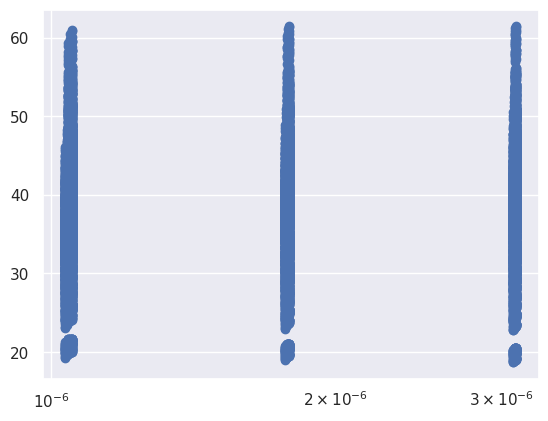

In [56]:
plt.scatter(area, gain)
plt.xscale("log")

In [57]:
len(diffpair_primitive_df)*len(activeload_primitive_df)*len(currentsource.parameters[Symbol("gcs")])

1014984

In [ ]:
currentsource.outputs[Symbol("W_cs")]

array([1.52675483e-04, 7.39684831e-06, 1.46218494e-04, 1.13832350e-05,
       1.65724132e-04, 1.87925004e-05, 2.35624714e-04, 3.42930442e-05,
       6.55756387e-05, 2.37188720e-04, 6.81196568e-06, 1.65154878e-06,
       2.29055192e-04, 9.81097515e-06, 2.78707788e-06, 2.52220758e-04,
       1.54285197e-05, 4.90450131e-06, 2.69577390e-05, 9.15593589e-06,
       5.06945448e-05, 1.79701847e-05, 8.60877447e-06, 1.68349428e-06,
       1.21470073e-05, 2.83992003e-06, 1.32010291e-06, 1.87189732e-05,
       4.95520109e-06, 2.35751770e-06, 3.25240174e-05, 9.14269463e-06,
       4.40004618e-06, 6.07067621e-05, 1.79537727e-05, 8.78621316e-06,
       1.15540466e-05, 1.85960921e-06, 1.57572732e-05, 3.15688194e-06,
       1.37153034e-06, 2.36239858e-05, 5.50507922e-06, 2.44851660e-06,
       1.42840305e-06, 4.05355165e-05, 1.02044449e-05, 4.54868701e-06,
       2.64248679e-06, 7.49861343e-05, 2.00095925e-05, 9.11852951e-06,
       5.34366284e-06, 1.61700726e-05, 2.10220858e-06, 2.11647362e-05,
      

: 

In [ ]:
OTA_macro.ext_mask = None

OTA_macro.primitives = [diffpair_primitive_wc, activeload_primmitive_wc, currentsource]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [gain_OTA, rout_OTA, gm_OTA]
OTA_macro.opt_specifications = [gain_OTA]
OTA_macro.is_primitive = 0
OTA_macro.run_pareto = False

_, _, _, ota_df_wc, ota_df_wc_mask = dfs(OTA_macro, debug = False)

############################################
Starting the exploration of:  OTA_macro
Netlist:  ota_1stage
Running MNA... 
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0


[('vout', 'vpos')]
Netlist:  ota_1stage_rout
Running MNA... 
   net1  vs  vneg  vout  vpos  vdd  vss  vr
0     1   2     3     4     5    6    0   7
[['vout', 'vr']]
Netlist:  ota_1stage
Running MNA... 
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0
[['vout', 'vpos']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
(-2*Raload_1**2*Rcs*Rdiff_1**2*gaload_1*gdiff_1**2 - 2*Raload_1**2*Rcs*Rdiff_1*gaload_1*gdiff_1 - Raload_1**2*Rdiff_1**2*gaload_1*gdiff_1 - Raload_1**2*Rdiff_1*gdiff_1 - Raload_1*Rcs*Rdiff_1**2*gdiff_1**2 - Raload_1*Rcs*Rdiff_1*gdiff_1 - Raload_1*Rdiff_1**2*gdiff_1)/(2*Raload_1**2*Rcs*Rdiff_1*gaload_1*gdiff_1 + 2*Raload_1**2*Rcs*gaload_1 + Raload_1**2*Rdiff_1*gaload_1 + Raload_1**2 + 2*Raload_1*Rcs*Rdiff_1**2*gaload_1*gdiff_1 + 2*Raload_1*Rcs*Rdiff_1*gaload_1 + 2*Raload_1*Rcs*Rdiff_1*gdiff_1 + 2*Raload_1*Rcs + Raload_1*Rdiff_1**2*gaload_1 + 2*Raload_1*Rdiff_1 + 2*Rcs*Rdiff_1**2*gdiff_1 + 2*Rcs*Rdiff_1 + Rdiff_1**2)
lambdi

In [ ]:
ota_df_wc["gain"] = 20*np.log10(ota_df_wc["gain_OTA"])
len(ota_df_wc)

13122

<Axes: xlabel='area', ylabel='gain'>

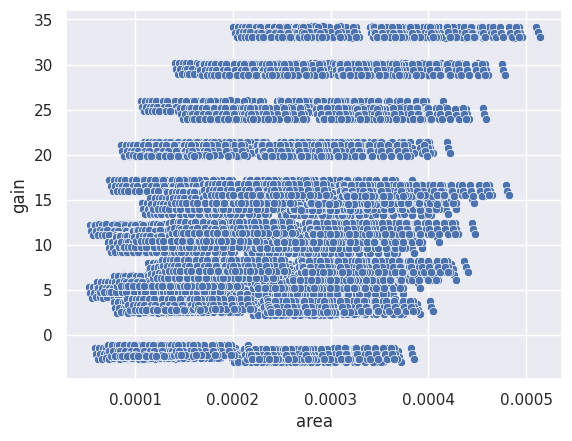

In [ ]:
sns.scatterplot(data=ota_df_wc, x="area", y="gain")

In [ ]:
OTA_macro.ext_mask = ota_df_wc_mask

OTA_macro.primitives = [diffpair_primitive, activeload_primmitive, currentsource]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [gain_OTA, rout_OTA, gm_OTA]
OTA_macro.opt_specifications = [gain_OTA]
OTA_macro.is_primitive = 0
OTA_macro.run_pareto = False

_, _, _, ota_df, _ = dfs(OTA_macro, debug = False)

############################################
Starting the exploration of:  ota_1stage
Netlist:  ota_1stage
Running MNA... 
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0
[('vout', 'vpos')]
Netlist:  ota_1stage_rout
Running MNA... 
   net1  vs  vneg  vout  vpos  vdd  vss  vr
0     1   2     3     4     5    6    0   7
[['vout', 'vr']]
Netlist:  ota_1stage
Running MNA... 
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0
[['vout', 'vpos']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
(-2*Raload_1**2*Rcs*Rdiff_1**2*gaload_1*gdiff_1**2 - 2*Raload_1**2*Rcs*Rdiff_1*gaload_1*gdiff_1 - Raload_1**2*Rdiff_1**2*gaload_1*gdiff_1 - Raload_1**2*Rdiff_1*gdiff_1 - Raload_1*Rcs*Rdiff_1**2*gdiff_1**2 - Raload_1*Rcs*Rdiff_1*gdiff_1 - Raload_1*Rdiff_1**2*gdiff_1)/(2*Raload_1**2*Rcs*Rdiff_1*gaload_1*gdiff_1 + 2*Raload_1**2*Rcs*gaload_1 + Raload_1**2*Rdiff_1*gaload_1 + Raload_1**2 + 2*Raload_1*Rcs*Rdiff_1**2*gaload_1*gdif

In [ ]:
ota_df["gain"] = 20*np.log10(ota_df["gain_OTA"])
len(ota_df)

13122

<Axes: xlabel='area', ylabel='gain'>

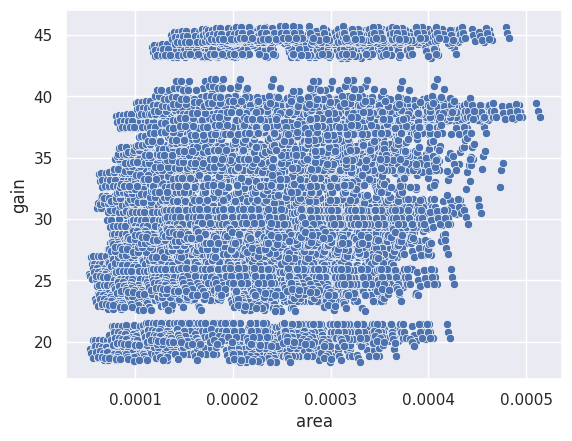

In [ ]:
sns.scatterplot(data=ota_df, x="area", y="gain")

In [ ]:
Cin_pt = 4.86e-12
ota_df["gain"] = 20*np.log10(ota_df["gain_OTA"])
ota_df["gain_wc"] = 20*np.log10(ota_df_wc["gain_OTA"])

ota_df["bw"] = 1/(2*np.pi*ota_df["rout_OTA"]*Cin_pt)

mask = ota_df["gain"]>10
ota_df = ota_df[mask]

ota_df_new = ota_df
ota_df_new.sort_values(by="gain")

,Rdiff_1,gdiff_1,vbias,vs_diff,Raload_1,gaload_1,vbias_cm,gcs,Rcs,vs_cs,...,W_aload_m1,L_aload_m1,W_aload_m2,L_aload_m2,W_cs,L_cs,area,gain,gain_wc,bw
3818,9.076737e+05,0.000164,1.6220,0.1,5.550670e+04,0.000147,-0.690,0.001251,11061.306992,0.1,...,0.000010,4.000000e-07,0.000008,4.000000e-07,0.000146,8.000000e-07,0.000238,18.312514,10.929113,624429.571106
3816,9.076737e+05,0.000164,1.6220,0.1,5.550670e+04,0.000147,-0.690,0.001346,10233.176140,0.1,...,0.000010,4.000000e-07,0.000008,4.000000e-07,0.000153,4.000000e-07,0.000244,18.319157,10.933708,624457.469329
3820,9.076737e+05,0.000164,1.6220,0.1,5.550670e+04,0.000147,-0.690,0.001125,10181.559012,0.1,...,0.000010,4.000000e-07,0.000008,4.000000e-07,0.000166,1.600000e-06,0.000259,18.319599,10.934014,624459.324005
3822,9.076737e+05,0.000164,1.6220,0.1,5.550670e+04,0.000147,-0.690,0.001016,8772.978393,0.1,...,0.000010,4.000000e-07,0.000008,4.000000e-07,0.000236,3.200000e-06,0.000330,18.333124,10.943371,624516.197545
2738,1.017119e+06,0.000164,1.6220,0.1,5.550670e+04,0.000147,-0.690,0.001251,11061.306992,0.1,...,0.000010,4.000000e-07,0.000008,4.000000e-07,0.000146,8.000000e-07,0.000207,18.366543,10.928630,620731.470710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100009,1.919392e+07,0.000189,1.4415,0.1,1.074891e+06,0.000203,-0.935,0.000470,2720.263842,0.1,...,0.000064,1.600000e-06,0.000063,6.400000e-06,0.000007,4.000000e-07,0.000249,45.687418,16.716286,32170.368791
100011,1.919392e+07,0.000189,1.4415,0.1,1.074891e+06,0.000203,-0.935,0.000385,2512.738824,0.1,...,0.000064,1.600000e-06,0.000063,6.400000e-06,0.000011,8.000000e-07,0.000253,45.687812,16.719788,32170.450355
100013,1.919392e+07,0.000189,1.4415,0.1,1.074891e+06,0.000203,-0.935,0.000333,2422.157048,0.1,...,0.000064,1.600000e-06,0.000063,6.400000e-06,0.000019,1.600000e-06,0.000261,45.687994,16.721407,32170.488053
100015,1.919392e+07,0.000189,1.4415,0.1,1.074891e+06,0.000203,-0.935,0.000304,2333.580207,0.1,...,0.000064,1.600000e-06,0.000063,6.400000e-06,0.000034,3.200000e-06,0.000278,45.688178,16.723046,32170.526244


In [ ]:
ota_df_wc_new = ota_df_wc[mask]
ota_df_wc_new

,Rdiff_1,gdiff_1,vbias,vs_diff,Raload_1,gaload_1,vbias_cm,gcs,Rcs,vs_cs,...,W_diff_m2,L_diff_m2,W_aload_m1,L_aload_m1,W_aload_m2,L_aload_m2,W_cs,L_cs,area,gain
0,1.566494e+07,0.000189,1.4415,0.1,22065.944055,0.000548,-0.69,0.001346,10233.176140,0.1,...,4.000000e-07,4.000000e-07,0.000010,4.000000e-07,0.000008,4.000000e-07,0.000153,4.000000e-07,0.000202,12.138174
1,1.566494e+07,0.000189,1.4415,0.1,22065.944055,0.000548,-0.69,0.000470,2720.263842,0.1,...,4.000000e-07,4.000000e-07,0.000010,4.000000e-07,0.000008,4.000000e-07,0.000007,4.000000e-07,0.000057,12.235878
2,1.566494e+07,0.000189,1.4415,0.1,22065.944055,0.000548,-0.69,0.001251,11061.306992,0.1,...,4.000000e-07,4.000000e-07,0.000010,4.000000e-07,0.000008,4.000000e-07,0.000146,8.000000e-07,0.000196,12.133936
3,1.566494e+07,0.000189,1.4415,0.1,22065.944055,0.000548,-0.69,0.000385,2512.738824,0.1,...,4.000000e-07,4.000000e-07,0.000010,4.000000e-07,0.000008,4.000000e-07,0.000011,8.000000e-07,0.000061,12.242580
4,1.566494e+07,0.000189,1.4415,0.1,22065.944055,0.000548,-0.69,0.001125,10181.559012,0.1,...,4.000000e-07,4.000000e-07,0.000010,4.000000e-07,0.000008,4.000000e-07,0.000166,1.600000e-06,0.000216,12.138456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104908,1.130414e+08,0.000164,1.6220,0.1,14077.704118,0.000652,-1.18,0.001125,10181.559012,0.1,...,1.600000e-06,6.400000e-06,0.000064,1.600000e-06,0.000020,6.400000e-06,0.000166,1.600000e-06,0.000332,6.954745
104909,1.130414e+08,0.000164,1.6220,0.1,14077.704118,0.000652,-1.18,0.000333,2422.157048,0.1,...,1.600000e-06,6.400000e-06,0.000064,1.600000e-06,0.000020,6.400000e-06,0.000019,1.600000e-06,0.000185,7.098479
104910,1.130414e+08,0.000164,1.6220,0.1,14077.704118,0.000652,-1.18,0.001016,8772.978393,0.1,...,1.600000e-06,6.400000e-06,0.000064,1.600000e-06,0.000020,6.400000e-06,0.000236,3.200000e-06,0.000403,6.966902
104911,1.130414e+08,0.000164,1.6220,0.1,14077.704118,0.000652,-1.18,0.000304,2333.580207,0.1,...,1.600000e-06,6.400000e-06,0.000064,1.600000e-06,0.000020,6.400000e-06,0.000034,3.200000e-06,0.000202,7.102482


/tmp/ipykernel_29990/4192085568.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend(loc = 'upper right')
/tmp/ipykernel_29990/4192085568.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend(loc = 'upper right')
/tmp/ipykernel_29990/4192085568.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend(loc = 'upper right')


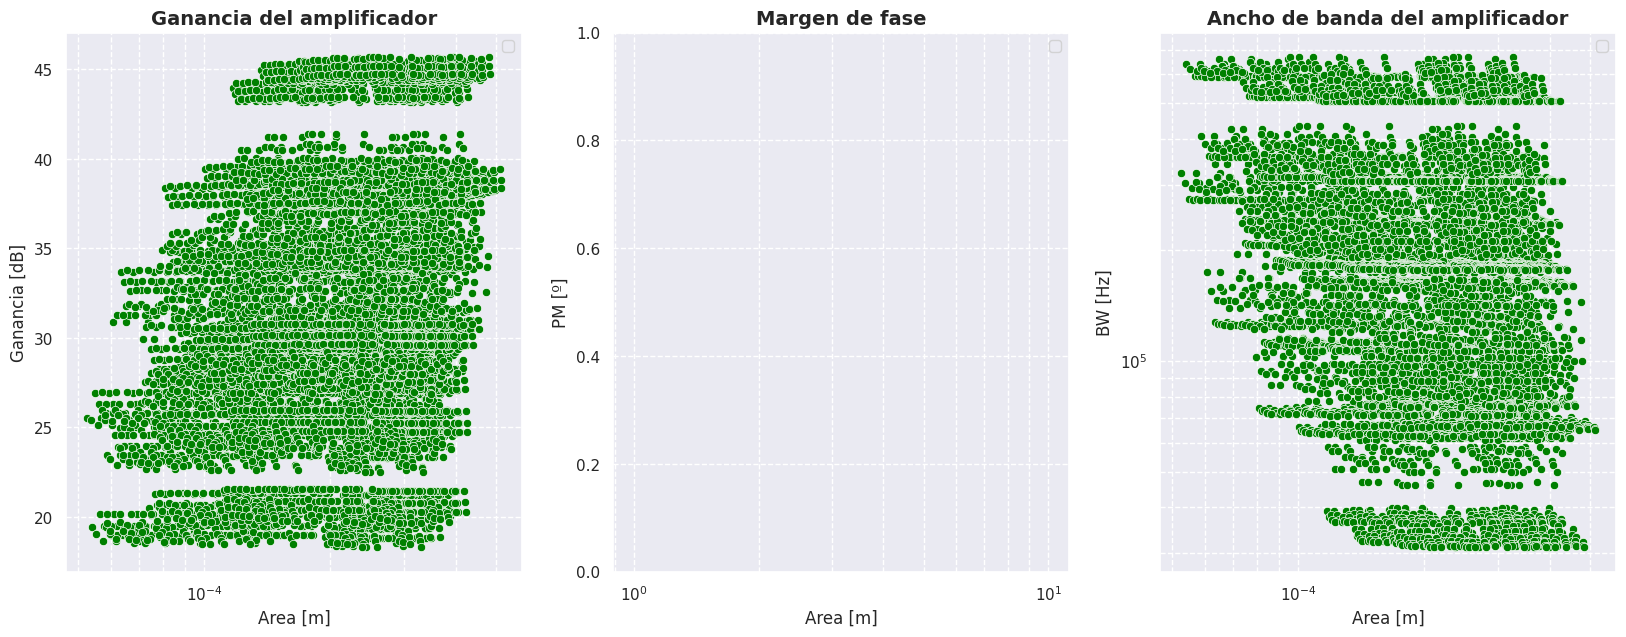

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
#sns.scatterplot(ax=axs[0], data=ota_df, x='area', y='gain', palette='flare')
sns.scatterplot(ax=axs[0], data=ota_df_new, x='area', y='gain', color="green")
#sns.scatterplot(ax=axs[1], data=ota_df, x="area", y="phase_margin_OTA", hue="phase_margin_OTA_wc", palette='flare')
#sns.scatterplot(ax=axs[1], data=ota_df_new, x="area", y="phase_margin_OTA", color="green")
#sns.scatterplot(ax=axs[2], data=ota_df, x="area", y="bw", hue_norm=LogNorm(), palette='flare')
sns.scatterplot(ax=axs[2], data=ota_df_new, x="area", y="bw", color="green")

axs[0].set_title(r"Ganancia del amplificador", fontsize=14, weight='bold')
axs[0].set_xlabel(r"Area [m]")
axs[0].set_ylabel(r"Ganancia [dB]")
axs[0].locator_params(axis='x', nbins=10) 
axs[0].legend(loc = 'upper right')

axs[1].set_title(r"Margen de fase", fontsize=14, weight='bold')
axs[1].set_xlabel(r"Area [m]")
axs[1].set_ylabel(r"PM [º]")
axs[1].legend(loc = 'upper right')

axs[2].set_xlabel(r"Area [m]")
axs[2].set_ylabel(r"BW [Hz]")
axs[2].set_title(r"Ancho de banda del amplificador", fontsize=14, weight='bold')
axs[2].legend(loc = 'upper right')

axs[0].grid(True,which="both",ls="--")  
axs[1].grid(True,which="both",ls="--")  
axs[2].grid(True,which="both",ls="--")  

axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[2].set_xscale('log')

axs[2].set_yscale('log')

#sns.move_legend(axs[0], "upper left",title="ganancia segunda etapa")

plt.savefig('fullcc_ota_explore_raw_SKY.pdf')